In [17]:
import numpy as np
from utils import *
from student_utils_sp18 import *
import networkx as nx
%matplotlib inline
print("networkx version: {}".format(nx.__version__))

networkx version: 2.1


In [18]:
# reading a file and get graph
lines = read_file("data/sample_input.txt")

num_kingdoms, kingdom_names, start_kingdom, adj_matrix = data_parser(lines)

# map kingdom names to indices
name2index = {}
index2name = {}

count = 1
for name in kingdom_names:
    name2index[name] = count
    index2name[count] = name
    count += 1

G = adjacency_matrix_to_graph(adj_matrix)

G

In [19]:
# initialize colors for each edge

color = {}

for node in G.nodes():
        color[node] = "white"
        
        
conquering_cost = {}
for node in G.nodes():
    conquering_cost[node] = adj_matrix[node][node]
    
nx.set_node_attributes(G, conquering_cost, "conquering_cost")
nx.set_node_attributes(G, color, "color")
# Example use G.node[1]['color'] gets the color of that node

In [20]:
# calculate the heuristic for all nodes on the graph

def conquer_gain(G, node):
    """Given a Graph and a node it calculates the value of the heuristic for the node"""
    """conquering_cost_neighbors/conquering_cost_current_node larger is better"""
    
    if G.node[node]['color'] =="black": # do not calculate the heuristic for black nodes
        return 0
    else:
        neighbors = nx.neighbors(G, node)
        
        neighbors_conquering_cost = 0
        for n in neighbors:
            neighbors_conquering_cost += G.node[n]['conquering_cost']
        
        return neighbors_conquering_cost/G.node[node]['conquering_cost']

In [21]:
# update the colors in the graph

def update_graph(G, node):
    G.node[node]['color'] = "black"
    neighbors = nx.neighbors(G, node)
    
    for n in neighbors:
        if G.node[n]['color'] == "white":
            G.node[n]['color'] = "grey"
    return

In [22]:
# find the the nodes that we need to visit based on heuristic

def choose_node(G):
    # calculate heuristic for everyone
    heuristic_value = []

    for node in G.nodes():
        heuristic_value.append(conquer_gain(G, node))

    chosen_node = np.argmax(heuristic_value)
    return chosen_node

def all_conquered(G):
    lst = [l[1] for l in nx.get_node_attributes(G, "color").items()]
    
    return not "white" in lst

In [23]:
# Identify components

nodes_to_visit = []

while not all_conquered(G):
    next_node = choose_node(G)
    nodes_to_visit.append(next_node)
    update_graph(G, next_node)

In [24]:
# another way to identify components using an approximation to the 
# min weight dominating set

from networkx.algorithms.approximation import *

min_weighted_dominating_set(G, "conquering_cost")

{0, 1}

In [25]:
# Get the Steiner Tree based on the nodes you have identofied
from networkx.algorithms.traversal import *

# GET THE FULL WALK

start_index = name2index[start_kingdom]
ST = steinertree.steiner_tree(G, nodes_to_visit+[start_index])

In [26]:
# recover the order of traversal of the tree

def find_traversal(tree, start_index):
    """Recovers the traversal of the Steiner tree using DFS (the full walk tho)"""
    
    vertex_order = list(dfs_preorder_nodes(tree, start_index))+[start_index]
    current_node = start_index
    full_walk = [start_index]

    for next_node in vertex_order[1:]:
        #print(current_node, next_node)
        path = list(nx.all_simple_paths(tree, current_node, next_node))[0]
        full_walk.extend(path[1:])
        current_node = next_node
    return full_walk

In [27]:
traversal = find_traversal(ST, start_index)
conquered = dict(zip(nodes_to_visit, [False]*len(nodes_to_visit)))
to_conquer = []

for n in traversal:
    if n in nodes_to_visit and conquered[n] == False:
        to_conquer.append(n)
        conquered[n]=True
        
print("Traversal: {}".format(traversal))
print("To conquer: {}".format(to_conquer))
ccost = sum(G.node[i]['conquering_cost'] for i in to_conquer)
tcost = sum(G.get_edge_data(traversal[i], traversal[i+1])['weight'] for i in range(len(traversal)-1))
print("Cost of conquering: {}".format(ccost))
print("Cost of travelling: {}".format(tcost))

Traversal: [2, 1, 0, 1, 2]
To conquer: [1, 0]
Cost of conquering: 3.0
Cost of travelling: 13.0


# Test run with Sue's input 1 file

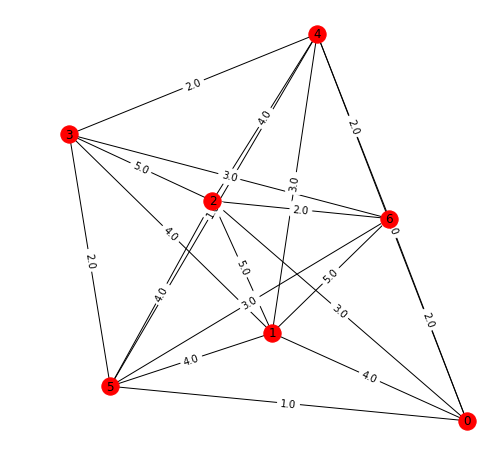

In [28]:
# reading a file and get graph
lines = read_file("data/input1.txt")

num_kingdoms, kingdom_names, start_kingdom, adj_matrix = data_parser(lines)

# map kingdom names to indices
name2index = {}
index2name = {}

count = 1
for name in kingdom_names:
    name2index[name] = count
    index2name[count] = name
    count += 1


G = adjacency_matrix_to_graph(adj_matrix)
pos = nx.spring_layout(G)
is_metric(G)

labels = nx.get_edge_attributes(G,'weight')
plt.figure(3,figsize=(8,8)) 
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
nx.draw(G, pos, with_labels=True)

In [29]:
def solver(G, start_index, adj_matrix):
    
    #adj_matrix = nx.adj_matrix(G).todense().tolist()
    
    # set the colors
    color = {}

    for node in G.nodes():
            color[node] = "white"


    conquering_cost = {}
    for node in G.nodes():
        conquering_cost[node] = adj_matrix[node][node]

    nx.set_node_attributes(G, conquering_cost, "conquering_cost")
    nx.set_node_attributes(G, color, "color")
    
    
    # find nodes to visit
    
    nodes_to_visit = []

    while not all_conquered(G):
        next_node = choose_node(G)
        nodes_to_visit.append(next_node)
        update_graph(G, next_node)
    
    # Handle the edge case from below
    if nodes_to_visit[0]==start_index:
        return [start_index], [start_index]
    
    # get Steiner tree
    # CURRENTLY HAS THE BUG THAT THE STEINER TREE DOES NOT WORK WHEN YOU ONLY HAVE 1 TARGET VERTEX
    ST = steinertree.steiner_tree(G, set(nodes_to_visit+[start_index]))

    # Find the traversal based on the Steiner tree
    traversal = find_traversal(ST, start_index)
    conquered = dict(zip(nodes_to_visit, [False]*len(nodes_to_visit)))
    to_conquer = []

    for n in traversal:
        if n in nodes_to_visit and conquered[n] == False:
            to_conquer.append(n)
            conquered[n]=True
            
    return traversal, to_conquer

In [30]:
solver(G, start_index, adj_matrix)

([2, 1, 2], [1])

In [31]:
for i in range(7):
    print("Conquering cost {}: {}".format(i, G.node[i]['conquering_cost']))

Conquering cost 0: 1.0
Conquering cost 1: 1.0
Conquering cost 2: 1.0
Conquering cost 3: 1.0
Conquering cost 4: 5.0
Conquering cost 5: 8.0
Conquering cost 6: 2.0


In [32]:
# print total cost for the tour

tour, conquer = solver(G, start_index, adj_matrix)

def calculate_cost(tour, conquer, G):
    cost = 0
    for i in range(len(tour)-1):
        cost += G.get_edge_data(tour[i], tour[i+1])['weight']

    for i in conquer:
        cost += G.node[i]['conquering_cost']
        
    return cost

calculate_cost(tour, conquer, G)

11.0

In [33]:
tour, conquer

([2, 1, 2], [1])

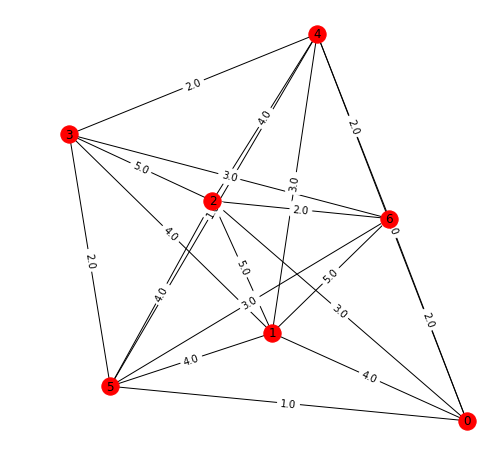

In [34]:
plt.figure(3,figsize=(8,8)) 
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
nx.draw(G, pos, with_labels=True)

## Test with Sona's input

In [35]:
adjacency_matrix = [[1, 4, 3, 'x'], 
                     [4, 1, 5, 13], 
                     [3, 5, 1, 12], 
                     ['x', 13, 12, 1]]

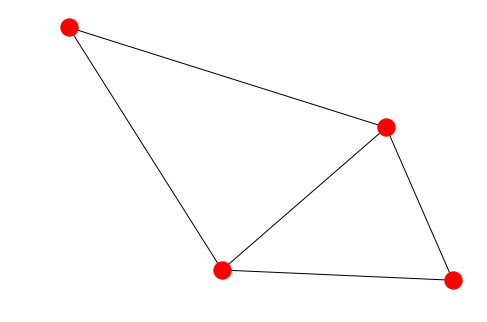

In [36]:
G = adjacency_matrix_to_graph(adjacency_matrix)
is_metric(G)

def draw_graph(G):
    pos = nx.spring_layout(G)
    labels = nx.get_edge_attributes(G,'weight')
    plt.figure(3,figsize=(8,8)) 
    nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
    nx.draw(G, pos, with_labels=True)
    
nx.draw(G)

In [37]:
tour, conquer = solver(G, 0, adjacency_matrix)

In [38]:
calculate_cost(tour, conquer, G)

9

### New input using random graphs

In [39]:
# idea to generate graph:
# 1. Make a random Erdos Renyi Graph
# 2. Connect fully
# 3. remove edges randomly

In [122]:
Q = nx.erdos_renyi_graph(200,0.6)
random_weights = np.random.randint(1, 10, len(Q.edges()))
dicti = dict(zip(list(Q.edges()), random_weights))
nx.set_edge_attributes(Q, dicti, "weight")

In [123]:
# make the fully connected path
# guarantees metric property

for lst in list(nx.shortest_paths.all_pairs_bellman_ford_path_length(Q)):
    start = lst[0]
    targets = lst[1]
    
    for end in targets.keys():
        if end!=start:
            try:
                Q.get_edge_data(start, end)['weight'] = targets[end]
            except:
                nx.set_edge_attributes(Q, {(start, end):targets[end]}, 'weight')
                
                
# randomly drop edges from the graph

In [124]:
for e in Q.edges():
    weight = Q.get_edge_data(e[0], e[1])['weight']
    if np.random.randn(0, 1)<0.8 and e not in nx.minimum_cut:
        Q.remove(e[0], e[1])
        
    if not nx.is_connected(Q):
        Q.add_edge(e[0], e[1], weight=weight)

/Users/Sona/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  app.launch_new_instance()


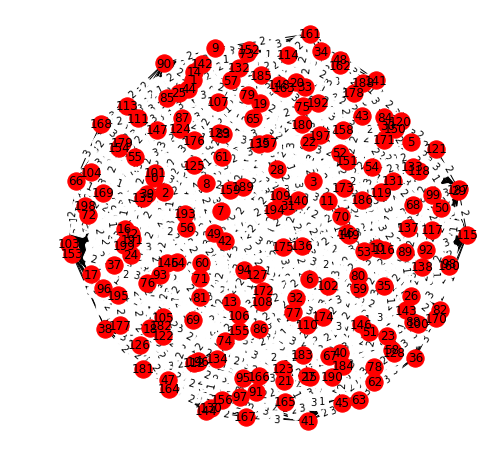

In [125]:
draw_graph(Q)

In [126]:
start_index = np.random.choice(np.arange(0, 10))
start_index

2

In [127]:
# randomly assign vertex weights
adj_matrix = nx.adj_matrix(Q).todense()
vertex_weights = np.random.randint(1, 10, len(adj_matrix))
adj_matrix[np.arange(len(adj_matrix)), np.arange(len(adj_matrix))] = vertex_weights
adj_matrix

matrix([[9, 3, 2, ..., 2, 3, 0],
        [3, 3, 0, ..., 0, 2, 3],
        [2, 0, 6, ..., 0, 3, 0],
        ...,
        [2, 0, 0, ..., 4, 1, 2],
        [3, 2, 3, ..., 1, 5, 2],
        [0, 3, 0, ..., 2, 2, 1]], dtype=int64)

In [128]:
names = [i for i in range(len(adj_matrix))]
np.savetxt('final_input200.txt', names, fmt='%.2f')
with open('final_input200.txt', 'w') as f:
    for line in adj_matrix.tolist():
        #np.savetxt(f, line, fmt='%.2f')
        f.write(str(line))

In [129]:
np.array(names)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [103]:
adj_list = adj_matrix.tolist()
adj

In [106]:
adj_matrix.shape
for line in adj_matrix:
    #print(list(line))
    print(line)
    print(len(adj_list))
    break

[[1 0 2 4 2 3 0 0 2 0 2 0 0 2 2 3 3 2 3 2 2 0 3 0 0 0 2 0 0 3 3 1 2 3 0 2
  3 0 2 0 3 3 3 0 3 0 0 0 0 0 0 0 3 0 4 0 1 3 0 2 0 0 3 3 3 0 0 1 2 0 0 2
  0 3 2 3 0 0 1 2 0 2 1 3 2 3 2 3 0 0 0 0 3 3 1 3 3 3 0 0]]
100


In [130]:
tour, conquer = solver(Q, 0, adj_matrix.tolist())
tour, conquer

([0, 46, 0, 65, 182, 65, 0, 70, 0, 97, 108, 97, 0], [46, 65, 182, 70, 108])

In [81]:
calculate_cost(tour, conquer, Q)

28

In [115]:
import sys
sys.path.append('..')
sys.path.append('../..')
import os
import argparse
import utils
import networkx as nx
import numpy as np
from student_utils_sp18 import *

# Change these if you want to allow files with different names and/or graph sizes
RANGE_OF_INPUT_SIZES = [50, 100, 200]
VALID_FILENAMES = ['50.in', '100.in', '200.in']
MAX_NAME_LENGTH = 20


def validate_input(input_file, params=[]):
    print('Processing', input_file)
    message, error = tests(input_file, params)
    print(message)


def validate_all_inputs(input_directory, params=[]):
    input_files = utils.get_files_with_extension(input_directory, 'in')

    for input_file in input_files:
        validate_input(input_file, params=params)


def tests(input_file, params=[]):
    input_data = utils.read_file(input_file)
    number_of_kingdoms, list_of_kingdom_names, starting_kingdom, adjacency_matrix = data_parser(input_data)
    message = ''
    error = False

    file_basename = os.path.basename(input_file)
    if file_basename not in VALID_FILENAMES:
        message += 'Your file is named {file_basename}. The allowed file names are: {RANGE_OF_INPUT_SIZES}'
        error = True

    for i in range(len(RANGE_OF_INPUT_SIZES)):
        if file_basename == VALID_FILENAMES[i] and (int(input_data[0][0]) > RANGE_OF_INPUT_SIZES[i]):
            message += 'Your file is named {file_basename}, but the size of the input is {input_data[0][0]}\n'
            error = True

    if not len(list_of_kingdom_names) == number_of_kingdoms:
        message += 'The number of kingdom names you listed ({len(list_of_kingdom_names)}) differs from the number you gave on the first line ({number_of_kingdoms})\n'
        error = True

    if not len(adjacency_matrix) == len(adjacency_matrix[0]) == number_of_kingdoms:
        message += 'The dimensions of your adjacency matrix ({len(adjacency_matrix)} x {len(adjacency_matrix[0])}) do not match the number of kingdoms you provided ({number_of_kingdoms})\n'
        error = True

    if not all(entry == 'x' or (type(entry) is float and entry > 0 and entry <= 2e9 and decimal_digits_check(entry)) for row in adjacency_matrix for entry in row):
        message += 'Your adjacency matrix may only contain the character "x", or strictly positive integers less than 2e+9, or strictly positive floats with less than 5 decimal digits\n'
        error = True

    adjacency_matrix_numpy = np.matrix(adjacency_matrix)
    if not np.all(adjacency_matrix_numpy.T == adjacency_matrix_numpy):
        message += 'Your adjacency matrix is not symmetric\n'
        error = True
    
    if not len(set(list_of_kingdom_names)) == len(list_of_kingdom_names):
        message += 'Your kingdom names are not distinct\n'
        error = True
    
    if not all(name.isalnum() and len(name) <= MAX_NAME_LENGTH for name in list_of_kingdom_names):
        message += 'One or more of your kingdom names are either not alphanumeric or are above the max length of {MAX_NAME_LENGTH}\n'
        error = True

    if not starting_kingdom in list_of_kingdom_names:
        message += 'Your starting kingdom is not in the list of kingdom names\n'
        error = True

    G = adjacency_matrix_to_graph(adjacency_matrix)

    if not nx.is_connected(G):
        message += 'Your graph is not connected\n'
        error = True

    if not is_metric(G):
        message += 'Your graph is not metric\n'
        error = True

    message += "If you've received no other error messages, then your input is valid!\n\n\n"
    return message, error

In [135]:
validate_input("50.in", params=[])


Processing 50.in
If you've received no other error messages, then your input is valid!





In [93]:
num_lines = sum(1 for line in open('final_input200.txt'))
num_lines

61

In [86]:
!python update

python: can't open file 'update': [Errno 2] No such file or directory


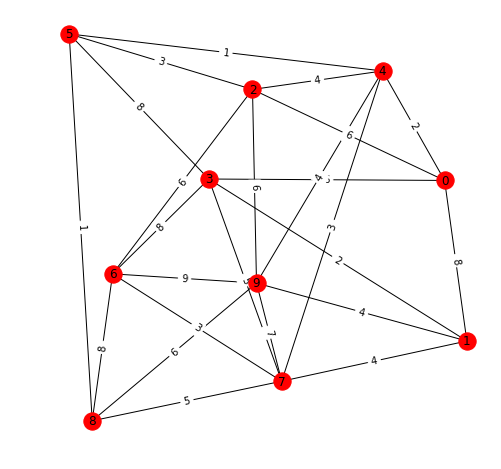

In [48]:
draw_graph(Q)

In [49]:
for i in range(len(Q.nodes)):
    print("Conquering cost {}: {}".format(i, Q.node[i]['conquering_cost']))

Conquering cost 0: 6
Conquering cost 1: 9
Conquering cost 2: 8
Conquering cost 3: 4
Conquering cost 4: 7
Conquering cost 5: 8
Conquering cost 6: 4
Conquering cost 7: 6
Conquering cost 8: 6
Conquering cost 9: 4


### Generate a new tree

In [50]:
# now try to generate a random tree
from networkx.generators.trees import random_tree

T = random_tree(10)
random_weights_edge = np.random.randint(1, 10, len(T.edges()))
random_weights_vertex = np.random.randint(1, 10, len(T.nodes()))

nx.set_edge_attributes(T, dict(zip(T.edges, random_weights_edge)), 'weight')

In [51]:
adj_matrix = nx.adj_matrix(T).todense()
adj_matrix[range(len(adj_matrix)), range(len(adj_matrix))] = random_weights_vertex
adj_matrix

matrix([[6, 0, 0, 0, 0, 0, 0, 0, 4, 0],
        [0, 2, 0, 7, 0, 0, 0, 0, 0, 0],
        [0, 0, 3, 5, 0, 0, 0, 0, 0, 0],
        [0, 7, 5, 6, 0, 2, 0, 6, 0, 6],
        [0, 0, 0, 0, 7, 0, 0, 0, 9, 0],
        [0, 0, 0, 2, 0, 8, 0, 0, 3, 0],
        [0, 0, 0, 0, 0, 0, 8, 0, 0, 9],
        [0, 0, 0, 6, 0, 0, 0, 6, 0, 0],
        [4, 0, 0, 0, 9, 3, 0, 0, 4, 0],
        [0, 0, 0, 6, 0, 0, 9, 0, 0, 2]], dtype=int64)

In [52]:
solver(T, start_index, adj_matrix.tolist())

([2, 3, 9, 3, 5, 8, 5, 3, 2], [3, 9, 8])

Start Index 2
Conquering cost 0: 6
Conquering cost 1: 2
Conquering cost 2: 3
Conquering cost 3: 6
Conquering cost 4: 7
Conquering cost 5: 8
Conquering cost 6: 8
Conquering cost 7: 6
Conquering cost 8: 4
Conquering cost 9: 2
tour: [2, 3, 9, 3, 5, 8, 5, 3, 2]
conquer: [3, 9, 8]
Total Cost 44


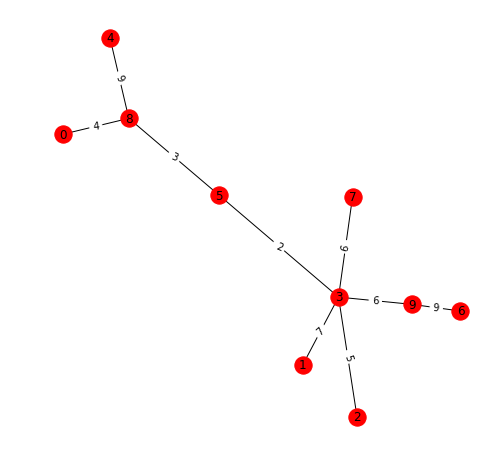

In [53]:
print("Start Index {}".format(start_index))

tour, conquer = solver(T, start_index, adj_matrix.tolist())

for i in range(len(T.nodes)):
    print("Conquering cost {}: {}".format(i, T.node[i]['conquering_cost']))

print("tour: {}".format(tour))
print("conquer: {}".format(conquer))
print("Total Cost {}".format(calculate_cost(tour, conquer, T)))
draw_graph(T)

Algo not so good in this case, need to find a good algo for weighted dominating set on tree.
A takeway is that in the case of very sparse stuff we don't need heuristics but more precise choice of vertices.
There actually exists a DP solution to weighted vertex cover for Trees.
I can check whether it is near-tree through the # of edges.

### Sparse graph oriented algorithm

For trees we do have dp algorithms that can solve min edge, vertex dominating set. If you have something that is very loosely connected you can try removing very heavy edges until it is a tree and then potentially run that algorithm on it. 

Another option would be to find an mst (isn't that what the above thing is tho) and then run the algo on it. 

I get it but implementation is a little tricky http://courses.csail.mit.edu/6.006/fall09/lecture_notes/lecture21.pdf

In [ ]:
def sparse_graph_algo(T, start_index):
    """OMG what the fuck did I just code up. AAAAARGH"""
    
    """
    This is a DP algorithm that given a tree calculate sthe 
    There are two cases:

    a) Root belongs to the vertex cover or it doesn't. In this case do 1 + size of left + size of right

    DP(v) = min. dom. set for subtree rooted at v
    DP'(v) = min. dom. set for subtree rooted at v not requiring v

    recursion

    DP(v) = min{1 + sum(DP'(c) for c in children[v]), # YES, DOMINATE the root v
                min_children{1 + sum(DP'(g) for g in children(d)) + sum(DP[c] for c new d in children[v])}}

    DP'(v) = min{1 + sum(DP'(c) for children[v]),
                 sum(DP[c] for c in children[v])}


    # I guess build everything up in post order
    """
    
    root = find_leaves(T)[0]

    T_prime = dfs_tree(T, root)

    post_order = list(dfs_postorder_nodes(T, root)) # using post order to traverse the nodes so leaves are up first


    dp = np.zeros(len(T.nodes))-1
    dp_prime = np.zeros(len(T.nodes))-1

    def is_leaf(node, T):
        return T.out_degree(node)==0 and T.in_degree(node)==1

    # establish the based cases for the two problems for the leaf nodes
    for ix in range(len(post_order)):
        node = post_order[ix]

        if is_leaf(node, T_prime):
            dp[ix] = 1 # start it easy and then change to accomodate weights
            dp_prime[ix] = 0

    # now let's build from the bottom up

    conquer = []

    for ix in range(len(post_order)):
        if dp[ix]!=-1:
            pass
        else:
            v = post_order[ix]
            #print(ix, v)
            children = list(T_prime.neighbors(v))
            children_ix = [post_order.index(c) for c in children]
            #print(children)

            ####### DP(v) UPDATE #########
            cost = T.node[v]['conquering_cost']

            if is_leaf(v, T_prime):
                parent = list(T_prime.predecessors(v))[0]
                cost += 2*T.get_edge_data(parent, v)['weight']

            # left part
            left = cost + sum([dp_prime[i] for i in children_ix]) #1 + sum(DP'(c) for c in children[v])

            # right part
            vals = []

            for d in children_ix:
                children2 = list(T_prime.neighbors(post_order[d]))
                children_ix2 = [post_order.index(c) for c in children2]
                cost2 = T.node[post_order[d]]['conquering_cost']

                if is_leaf(d, T_prime):
                    parent2 = list(T_prime.predecessors(d))[0]
                    cost2 += 2*T.get_edge_data(parent2, d)['weight']

                #print(c)
                #print(sum([dp[c] for i in children_ix if i!= d]))
                vals.append(cost2 + sum([dp_prime[i] for i in children_ix2]) + sum([dp[i] for i in children_ix if i!= d]))
            
            #print(vals)
            right = min(vals)

            dp[ix] = min(left, right)

            if left<right:
                conquer.append(post_order[ix])
                #print(post_order[ix])

            ####### DP'(v) UPDATE #########

            dp_prime[ix] = min(cost + sum([dp_prime[c] for c in children_ix]), sum([dp[c] for c in children_ix]))

            # store the result
            if dp_prime[ix] == cost + sum([dp_prime[c] for c in children_ix]):
                conquer.append(post_order[ix])
                #print(post_order[ix])

    conquer = list(set(conquer))
    
    # need to find a way to do the tour on the tree idk why but find_traversal does not work
    ST = steinertree.steiner_tree(T, conquer+[start_index])
    traversal = find_traversal(ST, start_index)
    return traversal, conquer

t, c = sparse_graph_algo(T, 8)
calculate_cost(t, c, T)

In [ ]:
# find mst first and the traversal, then decide efficiently which ones to conquer
from networkx.algorithms.tree.mst import minimum_spanning_tree

new= minimum_spanning_tree(T, weight="weight").nodes()

In [ ]:
draw_graph(T)

In [ ]:
# implementation of a min vertex cover. 
def find_leaves(G):
    leaves = []
    for n in G.nodes():
        if G.degree(n)==1:
            leaves.append(n)
    return leaves


def find_leaves_with_parent(parent, leaves, G):
    lst = []
    
    for leaf in leaves:
        if parent == list(T_prime.neighbors(leaf))[0]:
            lst.append(leaf)
    return lst



# testing tree
# tree = nx.Graph()
# tree.add_node(1)
# tree.add_node(2)
# tree.add_node(3)
# tree.add_node(4)

# tree.add_edge(1,2)
# tree.add_edge(1,3)
# tree.add_edge(2,4)
# tree.add_edge(2,5)
# tree.add_edge(5, 6)

# nx.draw(tree, with_labels=True)